<font color="orange">Weak approximations and VIX option price
expansions in forward variance curve models</font>

Convention is different. The parameter $\eta$ in the paper must be 
replaced with $\eta \sqrt{2H}$

Consider the SDE for the forward variance curve model
$$
    d\xi_t^u = \xi_t^u K(u,t) \, dW_t
$$
or equivalently, for all $u \geq T$,
$$
    \xi_T^u = \xi_0^u \exp \left\{ Z_T^u \right\}
$$
where 
$$
    Z_T^u = -\frac{1}{2}\int_0^T K(u,t)^2 dt + \int_0^T K(u,t) \, dW_t.
$$

We approximte the 

$$
    \text{VIX}_T^2 
    = \frac{1}{\Delta} \int_{T}^{T+\Delta} \xi_T^u du
    = \frac{1}{\Delta} \int_{T}^{T+\Delta} \xi_0^u \exp \{Z_T^u\} du
$$

with a lognormal proxy

$$
    \text{VIX}_{T,P}^2 = \mathbb{E}[\text{VIX}_T^2]
    \exp \left\{\frac{1}{\Delta} \int_{T}^{T+\Delta} \xi_0^u Z_T^u 
    \frac{du}{\mathbb{E}[\text{VIX}_T^2]}\right\}
$$

where fair price of a VIX squared futures contract is given by

$$
    \mathbb{E}[\text{VIX}_T^2] = \frac{1}{\Delta} 
    \int_{T}^{T+\Delta} \xi_0^u du.
$$

We have that $\log \text{VIX}_{T,P}^2$ is normal with mean

$$
    \mu_{P} = 
    \log \mathbb{E}[\text{VIX}_T^2] -
    \frac12 \int_0^T \left(\frac1\Delta 
    \int_{T}^{T+\Delta} \xi_0^u K(u,t)^2 \frac{du}{\mathbb{E}[\text{VIX}_T^2]} \right) \, dt
$$

and variance

$$
    \sigma_{P}^2 = 
    \int_0^T \left(\frac1\Delta 
    \int_{T}^{T+\Delta} \xi_0^u K(u,t) \frac{du}{\mathbb{E}[\text{VIX}_T^2]} \right)^2 \, dt
$$

We approximate the VIX option price by
$$
    \mathbb{E}[\varphi(\text{VIX}_{T}^2)] \approx
    \mathbb{E}[\varphi(\text{VIX}_{T,P}^2)]
    + \sum_{i=1}^{3} \gamma_i \, \mathbb{E}[\varphi(\text{VIX}_{T,P}^2 \, e^{\varepsilon})]|_{\varepsilon=0}
$$

The zero-th order approximation corresponds to a Black-Scholes price
while the other terms are corrections based on Black-Scholes Greeks (delta, gamma, speed).

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
from rbergomi import RoughBergomi
import matplotlib as mpl
import numpy as np
import seaborn as sns

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
COLORS = ["blue", "green", "red"]
SEED = 1234

In [3]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 1.0,
}

rbergomi = RoughBergomi(**params)

In [4]:
n_disc = 300
n_mc = 2 * 10**5

mats = {"1M": 1.0 / 12.0, "3M": 3.0 / 12.0, "6M": 6.0 / 12.0}

## Price of VIX futures as function of the vol-of-variance $\eta$

In [11]:
tab_eta = np.linspace(0.1, 1.5, 10) * np.sqrt(2.0 * params["H"])

# Monte Carlo price
vix_fut_eta = {}
for month in mats:
    print(month)
    price = np.zeros_like(tab_eta)
    for i, eta in enumerate(tab_eta):
        rbergomi.eta = eta
        price[i] = rbergomi.price_vix_fut(
            T=mats[month], n_disc=n_disc, n_mc=n_mc, seed=SEED
        )
    vix_fut_eta[month] = price

1M
3M
6M


In [12]:
# Approx price
vix_fut_eta_approx = {}
for month in mats:
    price = np.zeros_like(tab_eta)
    for i, eta in enumerate(tab_eta):
        rbergomi.eta = eta
        price[i] = rbergomi.price_vix_fut_approx(T=mats[month], order=3)
    vix_fut_eta_approx[month] = price

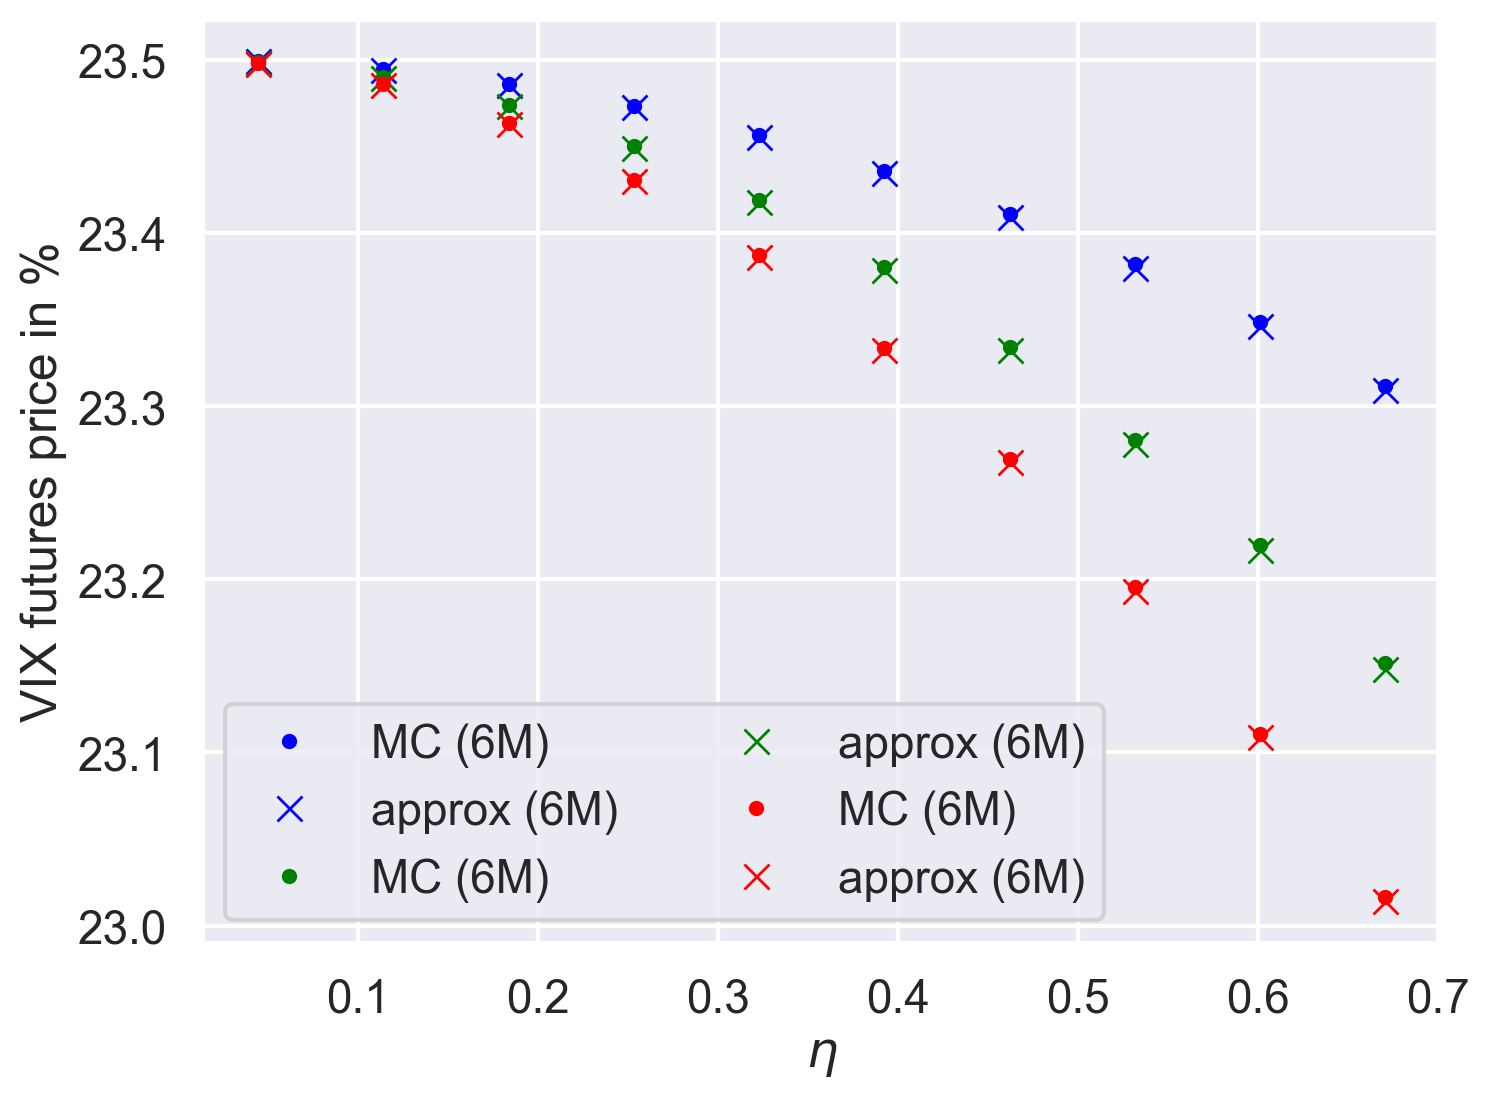

In [13]:
fig, ax = plt.subplots()
for i, T in enumerate(mats):
    ax.plot(
        tab_eta, 100.0 * vix_fut_eta[T], ".", color=COLORS[i], label=f"MC ({month})"
    )
    ax.plot(
        tab_eta,
        100.0 * vix_fut_eta_approx[T],
        "x",
        color=COLORS[i],
        label=f"approx ({month})",
    )
ax.set_xlabel("$\\eta$")
ax.set_ylabel("VIX futures price in %")
ax.legend(ncol=2)
plt.show()

## Price of VIX futures wrt the maturity $T$

In [ ]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 1.0,
}

rbergomi = RoughBergomi(**params)

tab_t = np.linspace(1.0 / 365.0, 1.0, 10)

vix_fut_t = np.array(
    [rbergomi.price_vix_fut(T=T, n_mc=n_mc, n_disc=n_disc, rule="trap") for T in tab_t]
)

In [17]:
vix_fut_t_approx = np.array(
    [rbergomi.price_vix_fut_approx(T=T, order=3) for T in tab_t]
)

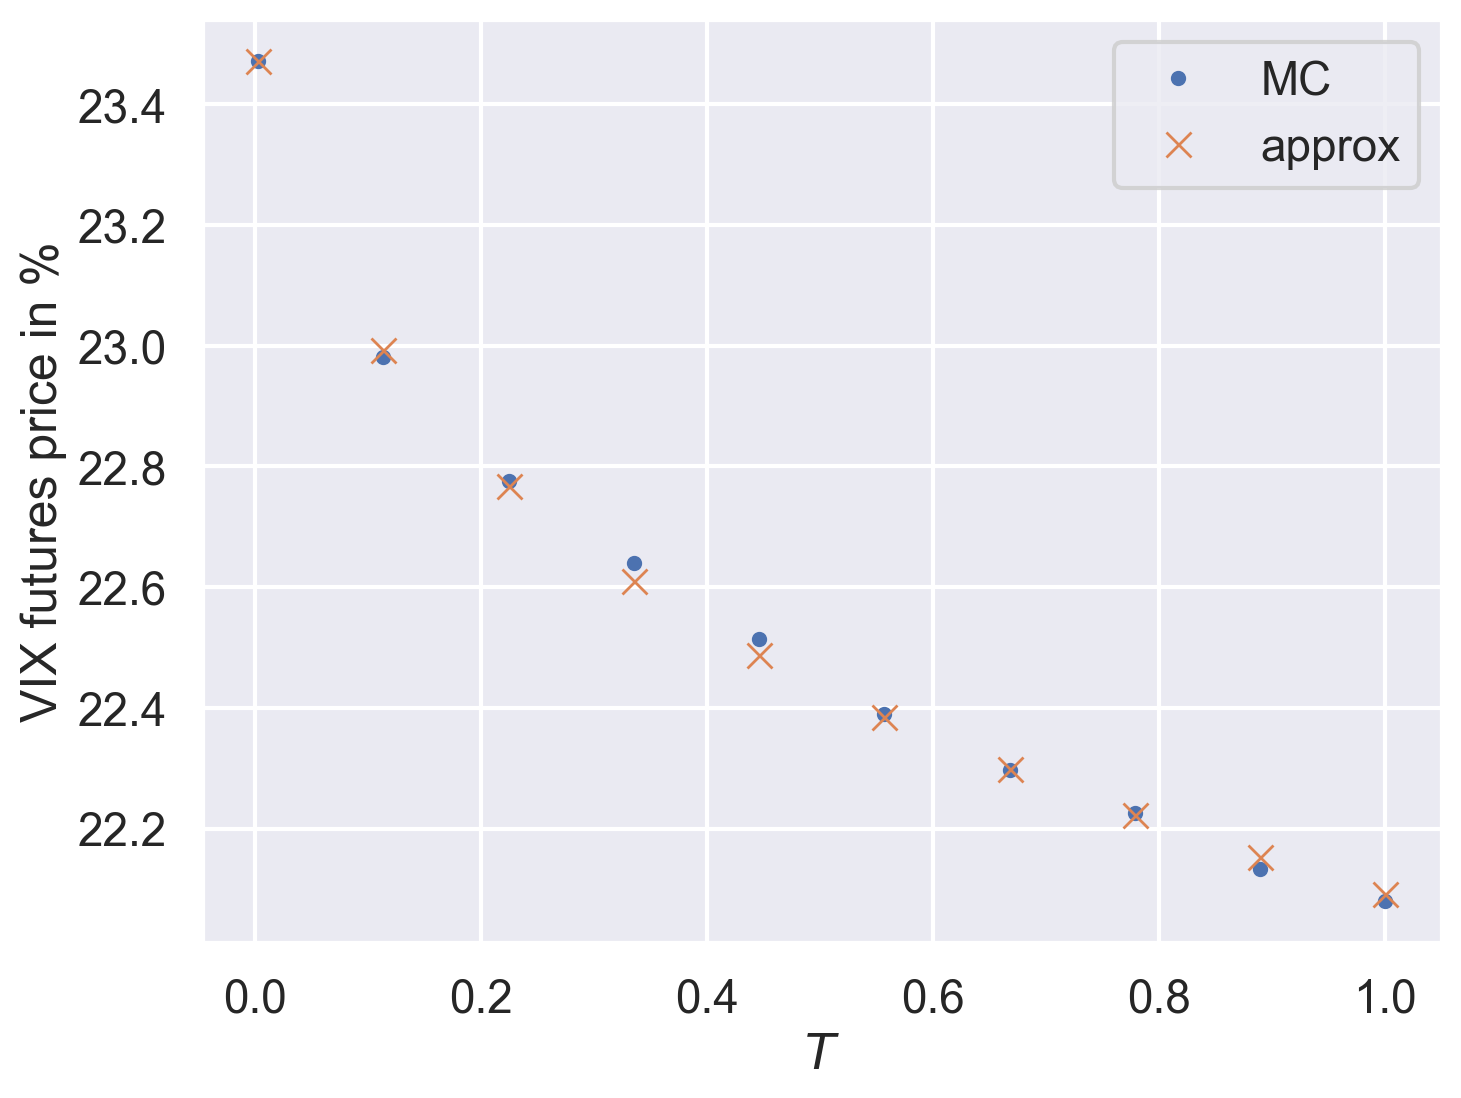

In [18]:
fig, ax = plt.subplots()
ax.plot(tab_t, 100.0 * vix_fut_t, ".", label="MC")
ax.plot(tab_t, 100.0 * vix_fut_t_approx, "x", label="approx")
ax.set_xlabel("$T$")
ax.set_ylabel("VIX futures price in %")
ax.legend()
plt.show()

## Price of VIX ATM call options as function of maturity $T$

In [19]:
vix_price_atm = np.array(
    [
        rbergomi.price_vix(k=0.0, T=T, n_mc=n_mc, n_disc=n_disc, rule="trap", opttype=1)
        for T in tab_t
    ]
)

In [20]:
vix_price_atm_approx = np.array(
    [rbergomi.price_vix_approx(k=0.0, T=T, order=3) for T in tab_t]
)

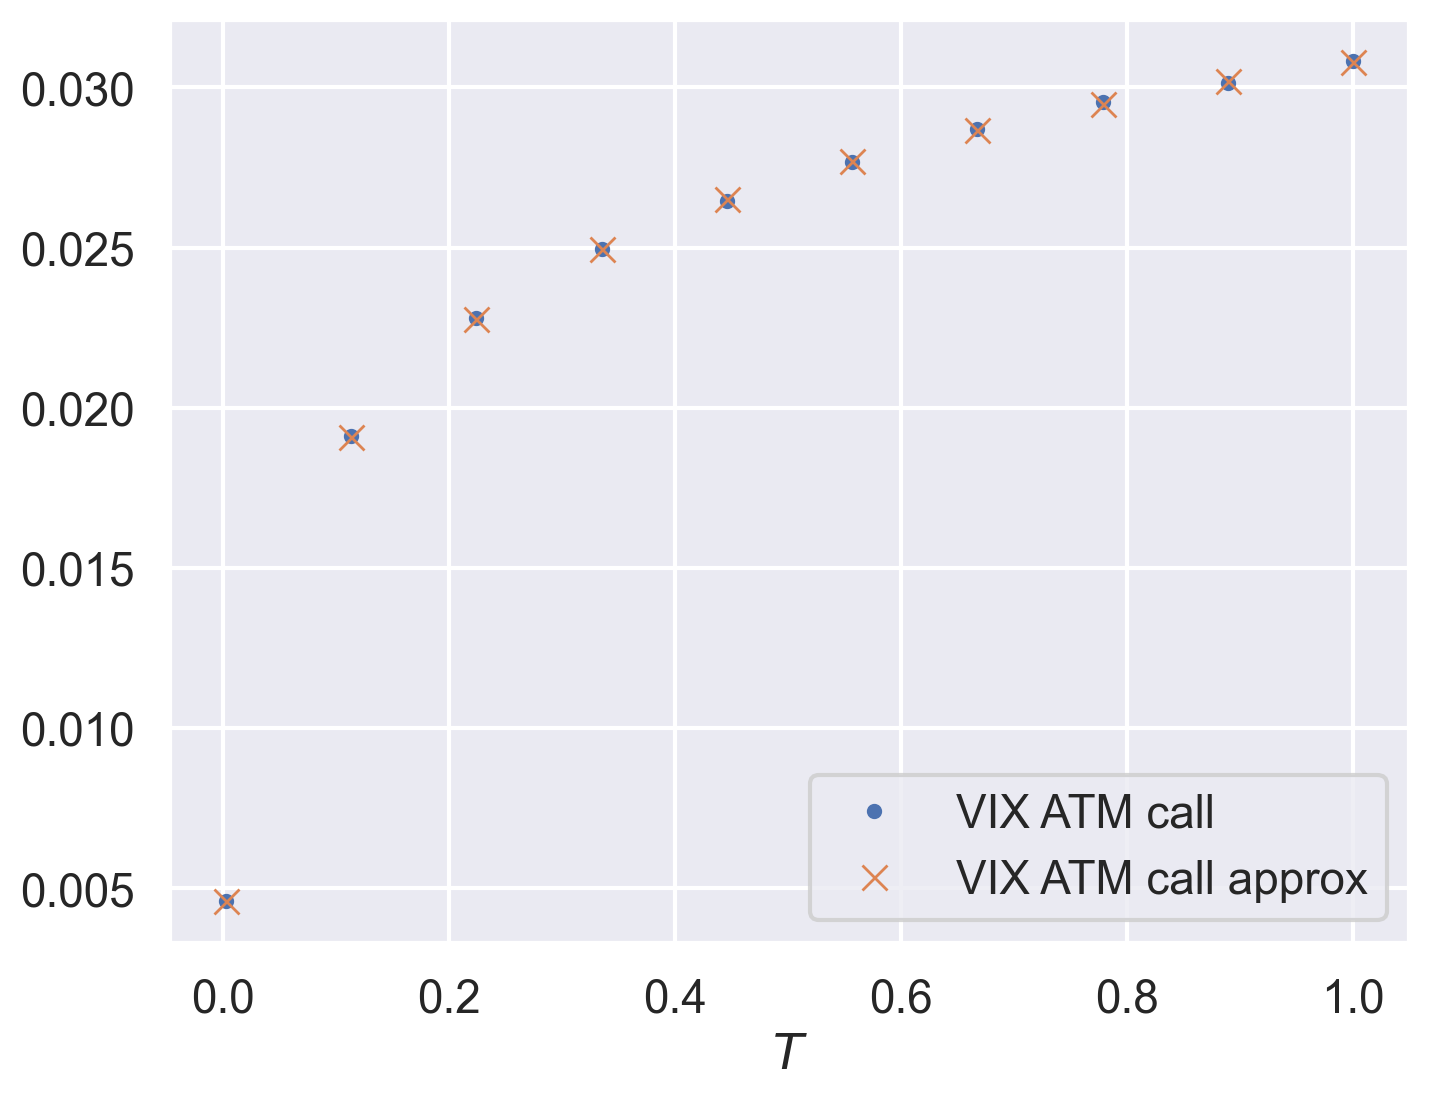

In [21]:
fig, ax = plt.subplots()
ax.plot(tab_t, vix_price_atm, ".", label="VIX ATM call")
ax.plot(tab_t, vix_price_atm_approx, "x", label="VIX ATM call approx")
ax.set_xlabel("$T$")
ax.legend()
plt.show()

## VIX implied volatility wrt the log-moneyness $k = \log(K/F)$

In [ ]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 1.0,
}

rbergomi = RoughBergomi(**params)

k = np.linspace(-0.1, 0.5, 11)

impvol_vix = {
    month: rbergomi.implied_vol_vix(k=k, T=T, n_disc=n_disc, n_mc=n_mc, seed=SEED)
    for month, T in mats.items()
}

In [23]:
impvol_vix_approx = {
    month: rbergomi.implied_vol_vix_approx(k=k, T=T, order=3)
    for month, T in mats.items()
}

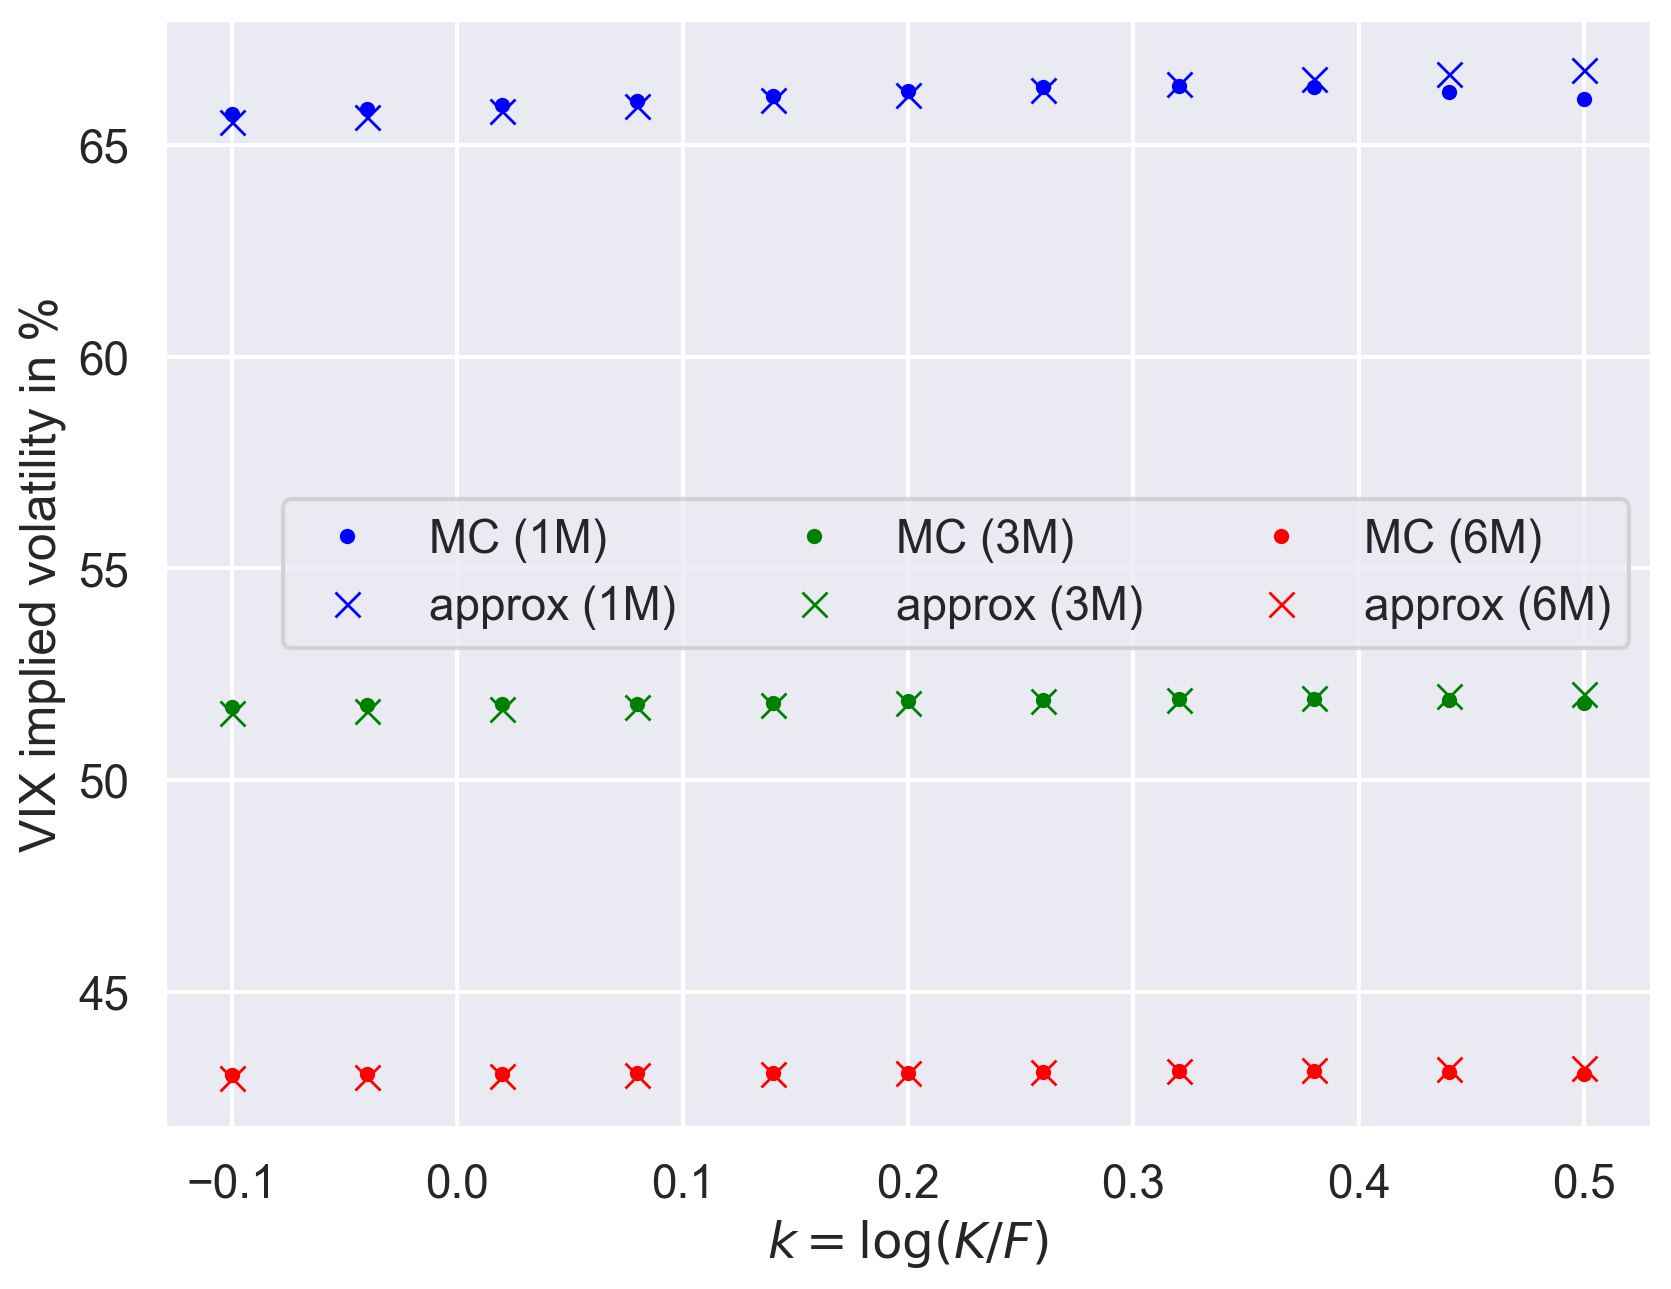

In [33]:
fig, ax = plt.subplots(figsize=(1.2 * 8, 1.2 * 6))
for i, month in enumerate(mats.keys()):
    ax.plot(k, 100 * impvol_vix[month], ".", color=COLORS[i], label=f"MC ({month})")
    ax.plot(
        k,
        100 * impvol_vix_approx[month],
        "x",
        color=COLORS[i],
        label=f"approx ({month})",
    )
ax.set_xlabel(r"$k=\log(K/F)$")
ax.set_ylabel("VIX implied volatility in %")
ax.legend(ncol=3)
plt.show()

## VIX implied volatility wrt the log-moneyness $k = \log(K/F)$ in the mixed case

In [24]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 1.0,
}

rbergomi = RoughBergomi(**params)

k = np.linspace(-0.1, 0.5, 11)
lbd = 0.3
eta_2 = 0.3

impvol_vix_mixed = {
    month: rbergomi.implied_vol_vix(
        lbd=lbd, eta_2=eta_2, k=k, T=T, n_disc=n_disc, n_mc=n_mc, seed=SEED
    )
    for month, T in mats.items()
}

In [33]:
impvol_vix_mixed_approx = {
    month: rbergomi.implied_vol_vix_approx_mixed(
        lbd=lbd, eta_2=eta_2, k=k, T=T, order=3, n_quad=80
    )
    for month, T in mats.items()
}

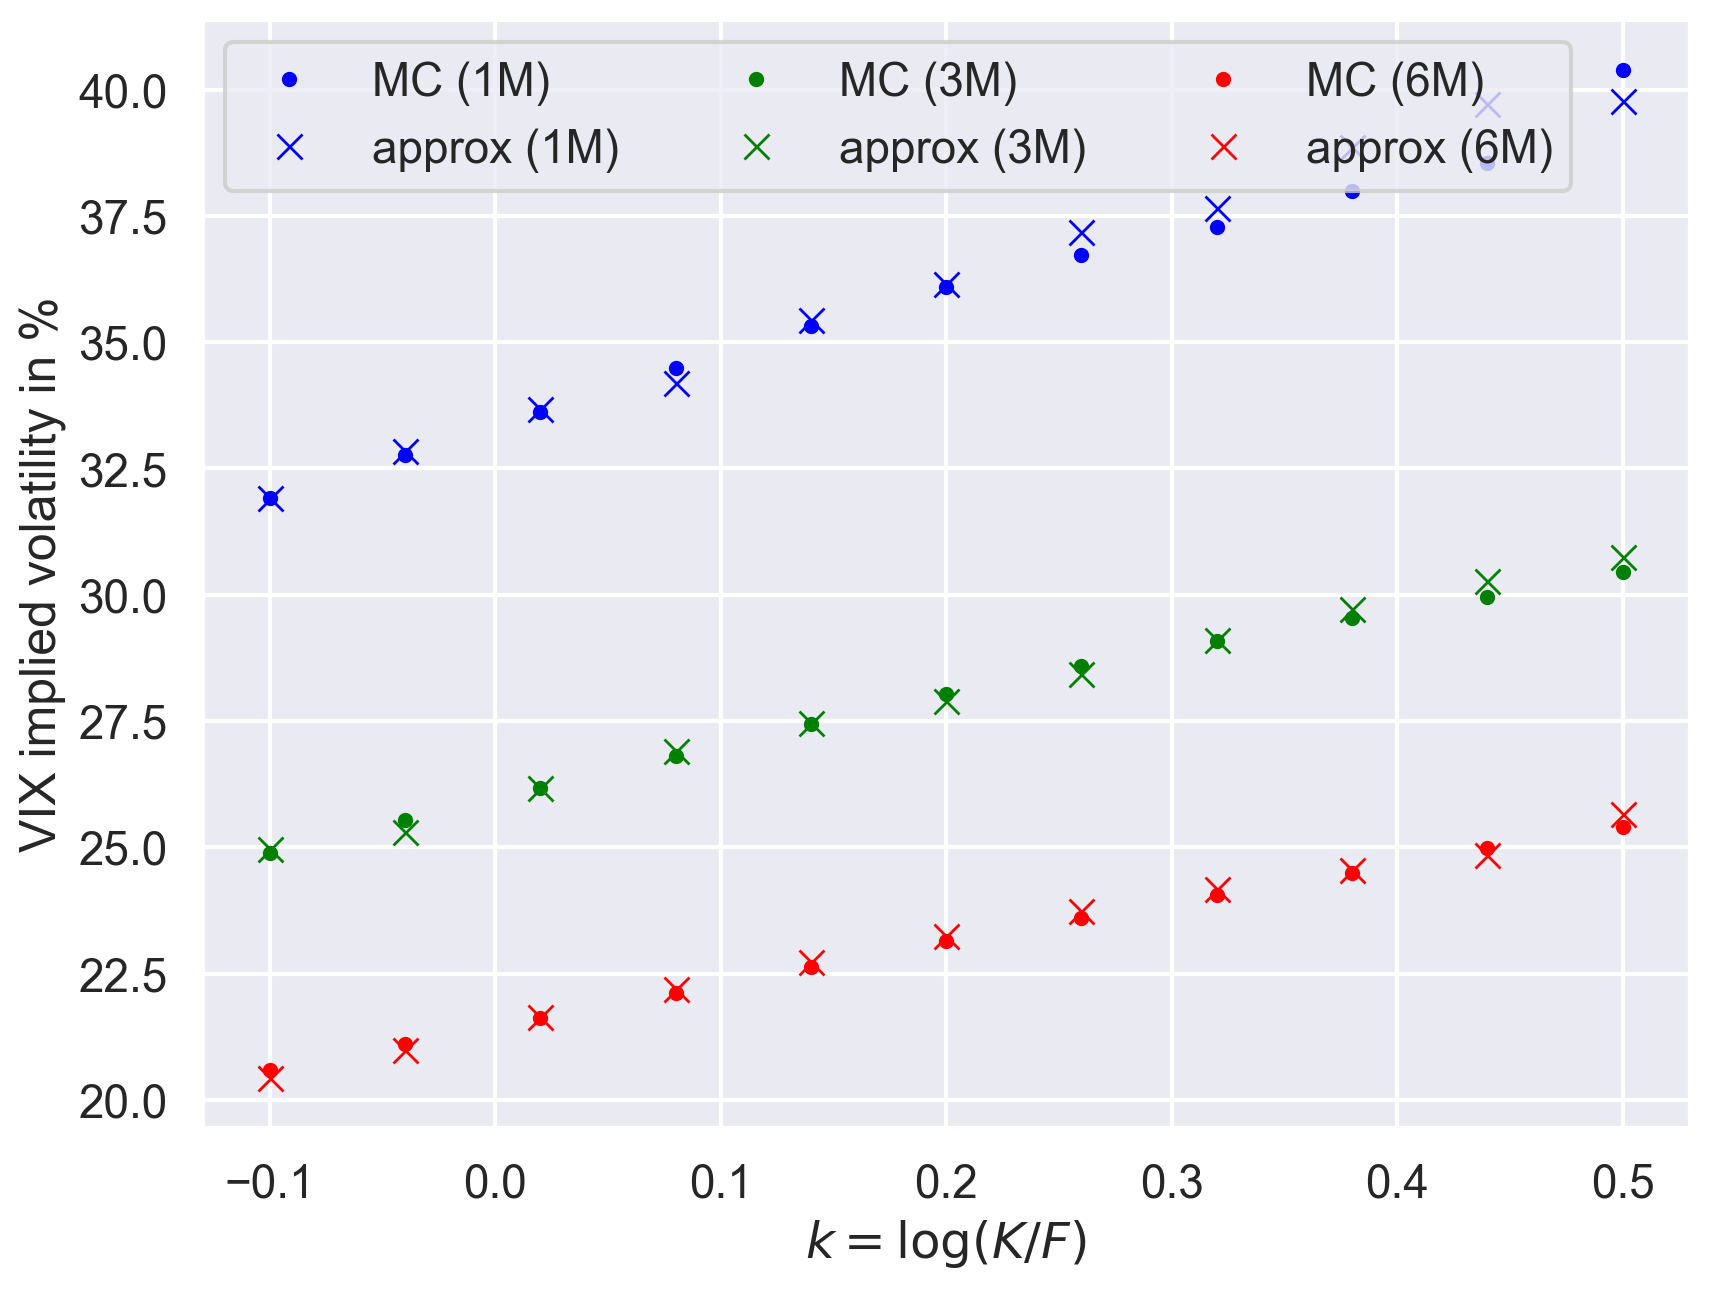

In [34]:
fig, ax = plt.subplots(figsize=(1.2 * 8, 1.2 * 6))
for i, month in enumerate(mats.keys()):
    ax.plot(
        k, 100 * impvol_vix_mixed[month], ".", color=COLORS[i], label=f"MC ({month})"
    )
    ax.plot(
        k,
        100 * impvol_vix_mixed_approx[month],
        "x",
        color=COLORS[i],
        label=f"approx ({month})",
    )
ax.set_xlabel(r"$k=\log(K/F)$")
ax.set_ylabel("VIX implied volatility in %")
ax.legend(ncol=3)
plt.show()

## VIX futures prices wrt T in the mixed case

In [8]:
tab_t = np.linspace(1.0 / 365.0, 1.0, 10)

vix_fut_t = np.array(
    [
        rbergomi.price_vix_fut(
            T=T, n_mc=n_mc, n_disc=n_disc, rule="trap", lbd=lbd, eta_2=eta_2
        )
        for T in tab_t
    ]
)

In [9]:
vix_fut_t

array([0.23492537, 0.23361591, 0.23313023, 0.23282572, 0.23249371,
       0.23209986, 0.23184749, 0.23166967, 0.23136423, 0.23124802])

In [22]:
vix_fut_t_approx = np.array(
    [
        rbergomi.price_vix_approx_mixed(
            T=T, lbd=lbd, eta_2=eta_2, order=3, opt_payoff="fut", K=0.0, n_quad=40
        )
        for T in tab_t
    ]
)

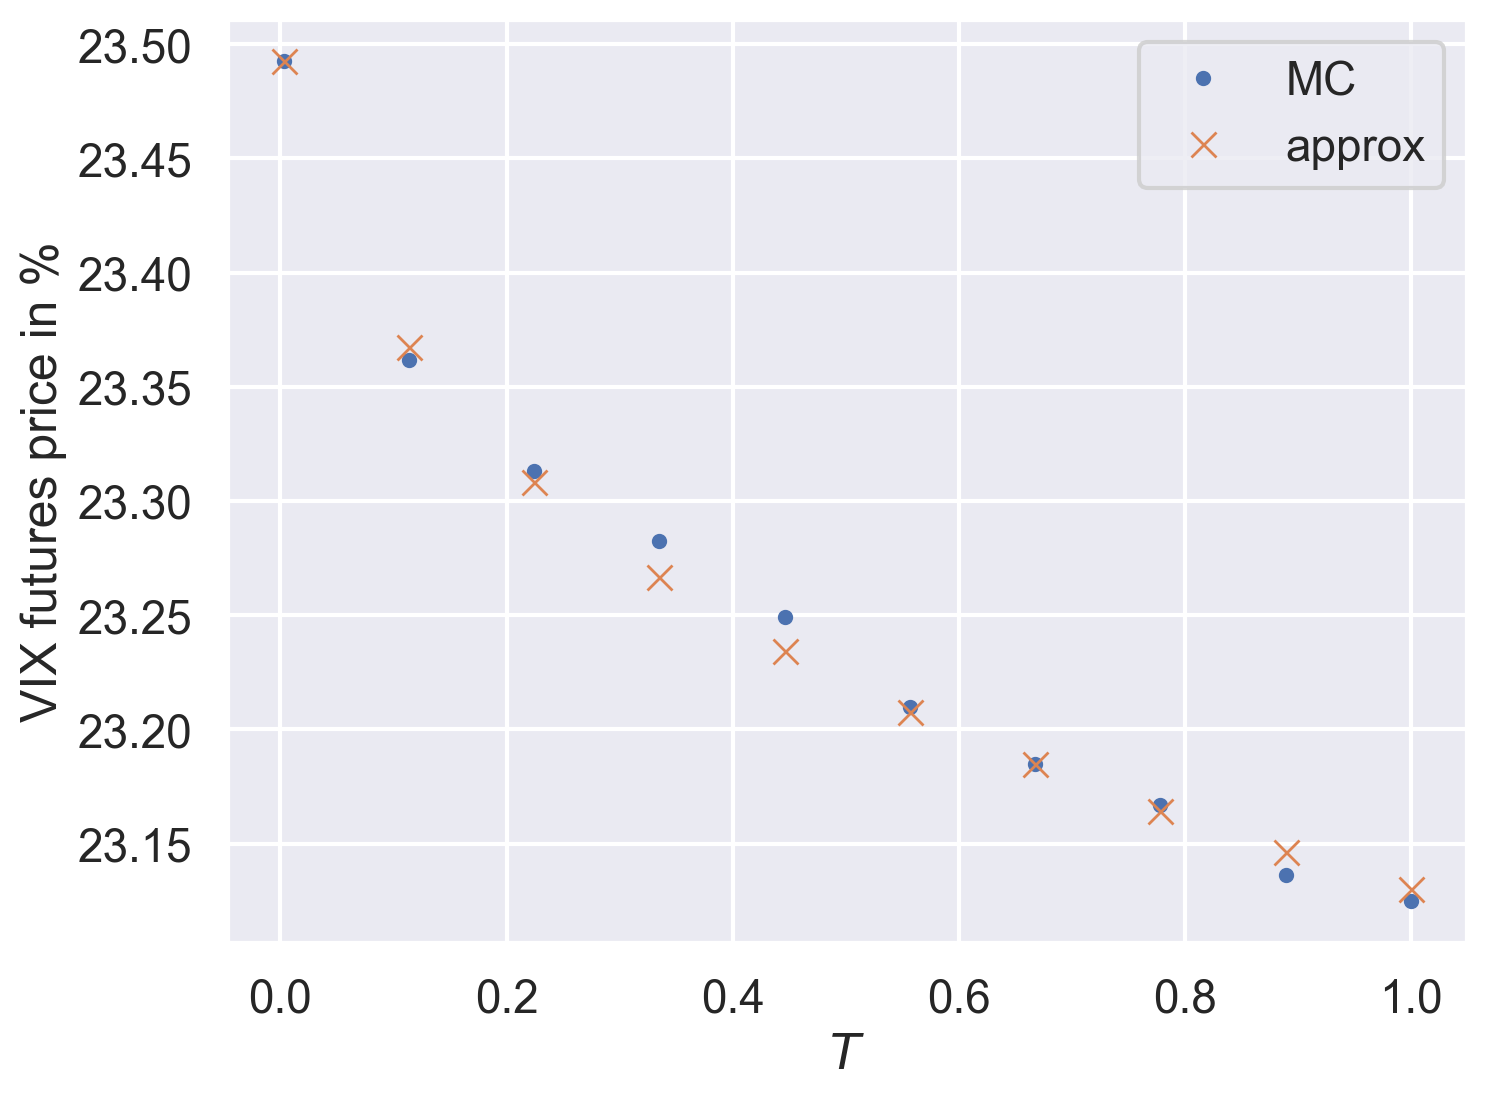

In [23]:
fig, ax = plt.subplots()
ax.plot(tab_t, 100.0 * vix_fut_t, ".", label="MC")
ax.plot(tab_t, 100.0 * vix_fut_t_approx, "x", label="approx")
ax.set_xlabel("$T$")
ax.set_ylabel("VIX futures price in %")
ax.legend()
plt.show()

In [67]:
# finish updating mixed methods. TODO: merge.
# first look at mlmc.